In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import h5py

from sklearn import metrics

from tensorflow import keras

import sys

from glob import glob

from scipy import stats

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
sys.path.append('../algorithms/')

In [4]:
import datatools

In [5]:
import pltconfig
pltconfig.apply_style(plt)

## Load Data

In [6]:
SIM="/gpfs/slac/atlas/fs1/d/rafaeltl/public/Muon/simulation/20220912/SIG_atlas_nsw_pad_z0_xya/"
SIG_LOC=f"{SIM}/TEST/*.h5"
BKG_LOC=f"{SIM}/BKG/*.h5"

files=glob(SIG_LOC) + glob(BKG_LOC)

print(len(files))

600


In [7]:
data, dmat, Y, Y_mu, Y_hit, sig_keys = datatools.make_data_matrix(files, max_files=700, sort_by='z')

~~ Reading data... ~~


100%|██████████| 600/600 [00:52<00:00, 11.42it/s]


~~ Calculating occupancy information... ~~


100%|██████████| 1499999/1499999 [00:43<00:00, 34181.47it/s]

!!
I read 1499999 events, of which 500000 have muon and 999999 do not
!!


## Occupancy plots

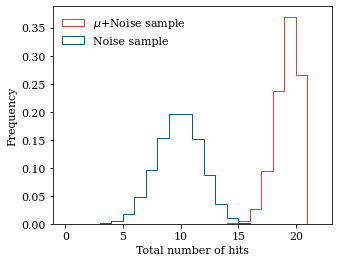

In [8]:
ncols, nrows = (1,1)
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(5*ncols,4*nrows))

axs.hist(data['ev_n_signals'][Y_mu==1], density=True, histtype='step', bins=22, range=(0,22), label=r'$\mu$+Noise sample')
axs.hist(data['ev_n_signals'][Y_mu==0], density=True, histtype='step', bins=22, range=(0,22), label='Noise sample')

axs.legend(loc='upper left', frameon=False)

axs.set_xlabel('Total number of hits')
axs.set_ylabel('Frequency')

plt.savefig('plots_noise/tot_hits.pdf', bbox_inches='tight')

plt.show()

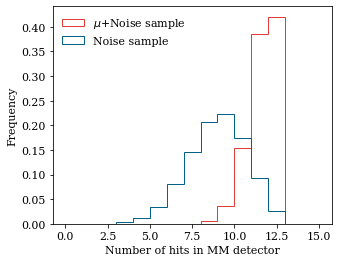

In [9]:
ncols, nrows = (1,1)
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(5*ncols,4*nrows))

axs.hist(data['n_sig_mm'][Y_mu==1], density=True, histtype='step', bins=15, range=(0,15), label=r'$\mu$+Noise sample')
axs.hist(data['n_sig_mm'][Y_mu==0], density=True, histtype='step', bins=15, range=(0,15), label='Noise sample')

axs.legend(loc='upper left', frameon=False)

axs.set_xlabel('Number of hits in MM detector')
axs.set_ylabel('Frequency')

plt.savefig('plots_noise/tot_hits_mm.pdf', bbox_inches='tight')

plt.show()

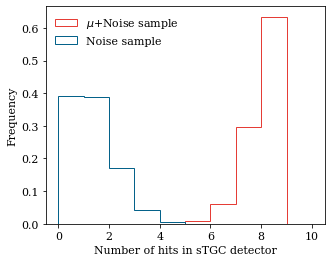

In [10]:
ncols, nrows = (1,1)
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(5*ncols,4*nrows))

axs.hist(data['n_sig_stgc'][Y_mu==1], density=True, histtype='step', bins=10, range=(0,10), label=r'$\mu$+Noise sample')
axs.hist(data['n_sig_stgc'][Y_mu==0], density=True, histtype='step', bins=10, range=(0,10), label='Noise sample')

axs.legend(loc='upper left', frameon=False)

axs.set_xlabel('Number of hits in sTGC detector')
axs.set_ylabel('Frequency')

plt.savefig('plots_noise/tot_hits_stgc.pdf', bbox_inches='tight')

plt.show()

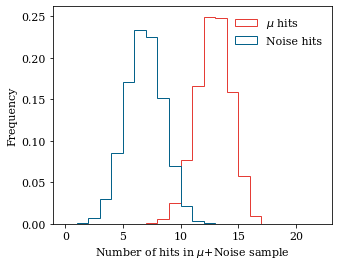

In [11]:
ncols, nrows = (1,1)
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(5*ncols,4*nrows))

axs.hist(data['ev_n_mu_signals'][Y_mu==1], density=1, histtype='step', bins=22, range=(0,22), label=f'$\mu$ hits')
axs.hist(data['ev_n_signals'][Y_mu==1]-data['ev_n_mu_signals'][Y_mu==1], density=1, histtype='step', bins=22, range=(0,22), label=f'Noise hits')

axs.legend(loc='upper right', frameon=False)

axs.set_xlabel(f'Number of hits in $\mu$+Noise sample')
axs.set_ylabel('Frequency')

plt.savefig('plots_noise/mu_hits.pdf', bbox_inches='tight')

plt.show()

## MM timing plots

In [12]:
X_det = datatools.detector_matrix(dmat, sig_keys, detcard=f"{SIM}/atlas_nsw_pad_z0.yml")

~~ Preparing detector-based data matrix ~~
Using detector card: /gpfs/slac/atlas/fs1/d/rafaeltl/public/Muon/simulation/20220912/SIG_atlas_nsw_pad_z0_xya//atlas_nsw_pad_z0.yml
[0, 5.1, 21.9, 27.0, 92.0, 103.5, 125.2, 125.2, 136.6, 136.6, 223.0, 223.0, 234.5, 234.5, 256.2, 267.6, 334.0, 339.1, 355.9, 361.0]


100%|██████████| 1499999/1499999 [06:58<00:00, 3580.68it/s]

Output data matrix shape: (1499999, 20, 20)


In [13]:
bc_time = X_det[:,:,sig_keys.index('time')].flatten()

In [14]:
is_mm_mu_id = ((X_det[:,:,sig_keys.index('ptype')]==0)*((X_det[:,:,sig_keys.index('is_signal')]==1))*((X_det[:,:,sig_keys.index('is_muon')]==1))).flatten()

In [15]:
is_mm_bkg_id = ((X_det[:,:,sig_keys.index('ptype')]==0)*((X_det[:,:,sig_keys.index('is_signal')]==1))*((X_det[:,:,sig_keys.index('is_muon')]==0))).flatten()

In [16]:
bc_time.shape

(29999980,)

In [17]:
is_mm_mu_id.shape

(29999980,)

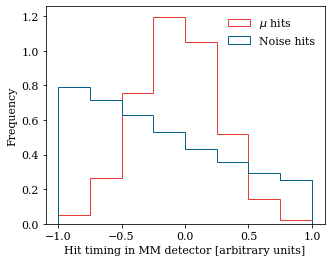

In [18]:
ncols, nrows = (1,1)
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(5*ncols,4*nrows))

axs.hist(bc_time[is_mm_mu_id], density=1, histtype='step',  bins=8, range=(-1,1), label=f'$\mu$ hits')
axs.hist(bc_time[is_mm_bkg_id], density=1, histtype='step', bins=8, range=(-1,1), label=f'Noise hits')

axs.legend(loc='upper right', frameon=False)

axs.set_xlabel(f'Hit timing in MM detector [arbitrary units]')
axs.set_ylabel('Frequency')

plt.savefig('plots_noise/bc_time.pdf', bbox_inches='tight')

plt.show()